### Plot Pairwise Correlations for Spheroid Aggregated data

In [91]:
import pandas as pd
import numpy as np
import os

from matplotlib.patches import Patch
from sklearn.metrics.pairwise import cosine_similarity

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("white")

# Set current working directory
print(os.getcwd())
os.chdir('/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1')
print(os.getcwd())

/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1
/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1


In [92]:
# Save the data
ImagesOut = '3_Figure4/PairwiseCorrelations/result-images/'

if not os.path.exists(ImagesOut): 
        os.makedirs(ImagesOut)

In [93]:
# Set up the plotting parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
dpi = 300
figformat = 'pdf'

In [94]:
cell_line = 'HCT116'
data_type = 'MIP'

In [95]:
# Load the data
dir = '1_Data/results/'
data =  pd.read_parquet(('{}grit_data_{}_{}.parquet').format(dir, data_type, cell_line))
data.dropna(axis='columns', how='all', inplace=True)

In [96]:
# Some function definitions

def list_features(df):
    # List features
    list_of_selected_features = list(df.columns.values)
    list_of_metadata = list(df.columns[df.columns.str.contains("Metadata_")])
    list_of_selected_features = list(set(list_of_selected_features) - set(list_of_metadata))
    
    return list_of_selected_features, list_of_metadata


def analyze_pathways(
    dataset, col_colors, filter_criteria="Metadata_grit > 2", 
    correlation_method='pearson', cluster_method='average'):
    
    

    """
    Analyze and plot pathway relationships using either correlation or cosine similarity.

    Parameters:
    - dataset (pd.DataFrame): DataFrame containing pathway data with metadata.
    - pathways_dict (dict): Dictionary mapping compounds to their respective pathways.
    - filter_criteria (str): Query string for filtering the dataset. Default is 'Metadata_grit > 2'.
    - correlation_method (str): Method to compute similarity. Options are 'pearson' (correlation) 
                                and 'cosine' (cosine similarity). Default is 'pearson'.
    - cluster_method (str): Clustering method for heatmap. Default is 'average'.

    Returns:
    - None: Displays a cluster map with pathway annotations.
    """
    # Step 1: Prepare and filter the dataset
    t = dataset.copy()
    meta = t[list_features(t)[1]]
    t = t.query('Metadata_pert_type == "trt"')
    t = t.groupby('Metadata_pert_name').median(numeric_only=True)
    t.drop(['Metadata_cmpd_conc'], axis=1, inplace=True)
    t = t.query(filter_criteria)
    data = t[list_features(t)[0]]

    # Step 2: Calculate similarity matrix
    if correlation_method == 'pearson':
        # Use correlation
        sim_matrix = data.T.corr()
        sim_name = 'cor'
    elif correlation_method == 'cosine':
        # Use cosine similarity
        sim_matrix = pd.DataFrame(
            cosine_similarity(data),
            index=data.T.columns, columns=data.T.columns
        )
        sim_name = 'cosine_sim'
    else:
        raise ValueError("Invalid correlation_method. Use 'pearson' or 'cosine'.")

    # Step 3: Reshape and map compound names
    m = sim_matrix.stack().to_frame(name=sim_name).reset_index(names=['pert_x', 'pert_y'])
    pert_to_name = dict(zip(meta.Metadata_pert_name, meta.Metadata_name))
    m['name_x'] = m['pert_x'].map(pert_to_name)
    m['name_y'] = m['pert_y'].map(pert_to_name)
    p = pd.pivot_table(m, values=sim_name, index='name_y', columns='name_x', aggfunc='max')

    # # Step 4: Map compounds to pathways
    # pathways = pd.Series({col: pathways_dict.get(col, 'Pathway not found') for col in p.columns})

    # # Step 5: Generate colormap
    # unique_paths = pathways.unique()
    # # cmap_choice = plt.cm.get_cmap('tab10', len(unique_paths)) if len(unique_paths) <= 10 else plt.cm.get_cmap('tab20', len(unique_paths))
    # # colors = [plt.cm.colors.to_hex(cmap_choice(i)) for i in range(len(unique_paths))]

    # colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a']
    # lut = dict(zip(unique_paths, colors))
    # col_colors = pathways.map(lut)

    # Step 6: Plot clustermap
    ax1 = sns.clustermap(
        p,
        cmap='RdBu_r',
        xticklabels=1,
        yticklabels=1,
        cbar_pos=(0.01, 0.9, 0.01, 0.18),
        tree_kws=dict(colors='#ddd'),
        cbar_kws=dict(shrink=0.2),
        method=cluster_method,
        dendrogram_ratio=0.1,
        col_colors=col_colors,
    )

    # Step 7: Add legend
    handles = [Patch(facecolor=lut[name]) for name in lut]
    plt.legend(handles, lut, title='Pathway',
               bbox_to_anchor=(1.2, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
    plt.show()

    # Step 1: Exclude diagonal elements
    p_no_diag = p.copy()
    np.fill_diagonal(p_no_diag.values, np.nan)

    # Step 2: Convert to long format
    similarities = p_no_diag.unstack().reset_index()
    similarities.columns = ['Item1', 'Item2', 'Similarity']

    # Step 3: Remove duplicate pairs
    similarities['Pair'] = similarities.apply(
        lambda row: tuple(sorted([row['Item1'], row['Item2']])), axis=1
    )
    similarities = similarities.drop_duplicates(subset='Pair')
    similarities = similarities.drop(columns='Pair')

    # Step 4: Drop NaN similarities
    similarities = similarities.dropna(subset=['Similarity'])

    # Step 5: Sort similarities
    similarities = similarities.sort_values(by='Similarity', ascending=False)

    # Step 6: Get top 10 most similar pairs
    top_10_similar_pairs = similarities.head(10)
    print(top_10_similar_pairs)
    return ax1, p



### Pairwise Correlations

In [97]:
# Create a dictionary of pathways and their associated compounds.
compounds = data['Metadata_name'].unique()
pathways_dict = {cmpd: data[data['Metadata_name'] == cmpd]['Metadata_pathway'].unique()[0] for cmpd in compounds}

pathways = pd.Series(pathways_dict).unique()
pathways = pd.Series(pathways).dropna()
pathways = pathways[~pathways.isin(['etop', 'dmso', 'stau', 'fenb', 'water', 'sorb'])]
pathways

# Create a color map for the pathways
colors = sns.color_palette('tab20', len(pathways))
lut = dict(zip(pathways, colors))
col_colors = pd.Series(pathways_dict).map(lut)

In [98]:
## Prepare the metadata for the Pairwise calculation

# ## Prepare the metadata for the grit calculation
dataset_pw  = data.copy()

# Create a dictionary of pathways and their associated compounds.
compounds = dataset_pw['Metadata_name'].unique()
pathways_dict = {cmpd: dataset_pw[dataset_pw['Metadata_name'] == cmpd]['Metadata_pathway'].unique()[0] for cmpd in compounds}
pathways = pd.Series(['MAPK','Cell Cycle', 'DNA Damage', 
                      'PI3K/Akt/mTOR', 'Epigenetics', 'Stem Cells & Wnt', 
                      'Angiogenesis', 'Protein Tyrosine Kinase', 
                      'Apoptosis', 'JAK/STAT', 'Cytoskeletal Signaling', 
                      'TGF-beta/Smad', 'Others', 'Proteases'])

# Create a color map for the pathways
colors = sns.color_palette('tab20', len(pathways))
lut = dict(zip(pathways, colors))
col_colors = pd.Series(pathways_dict).map(lut)


HCT116 - MIP - Pathway Similarity


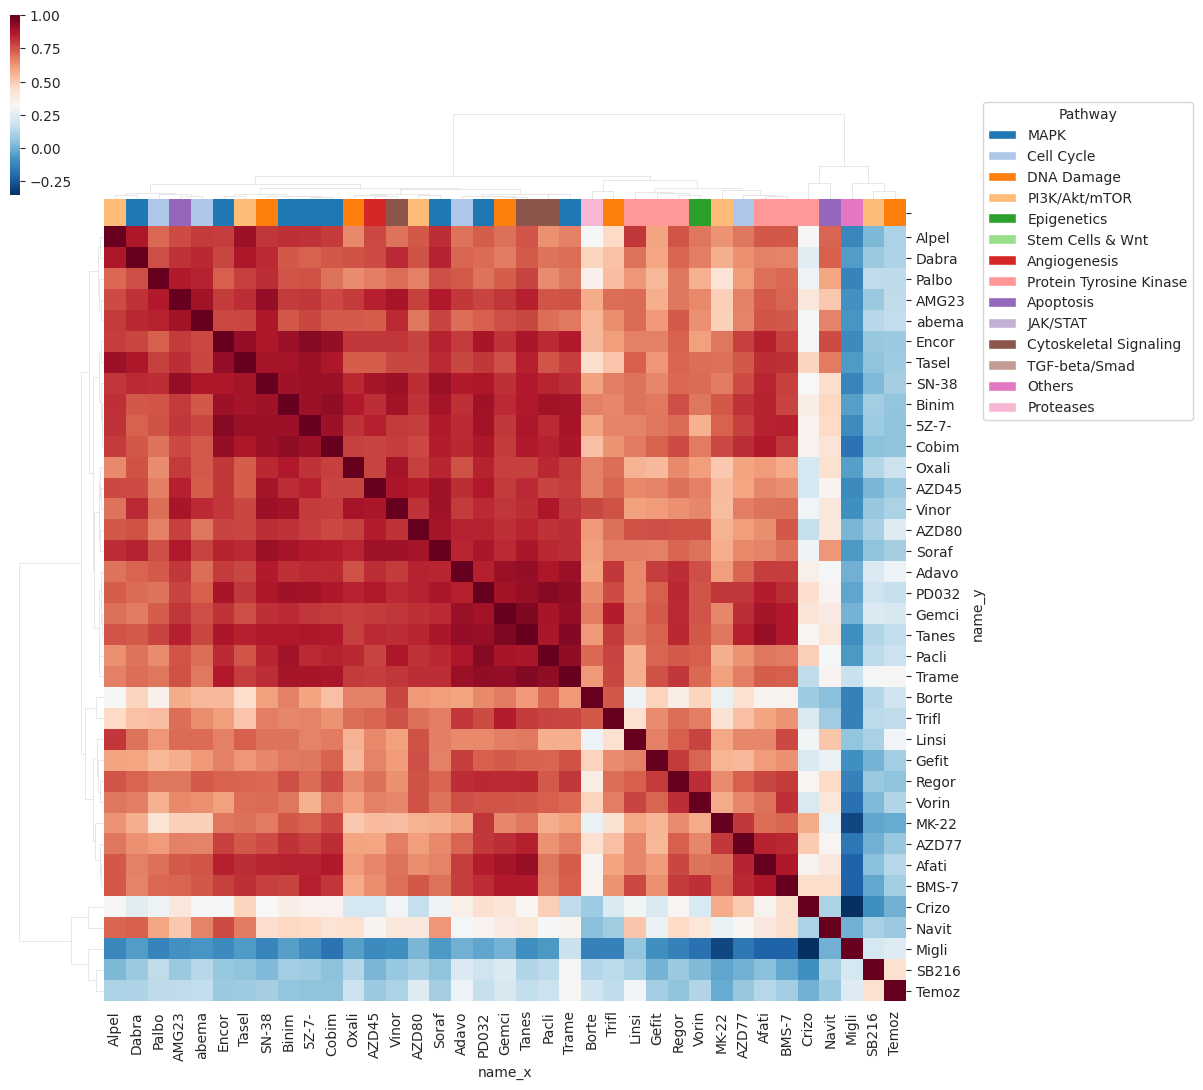

      Item1  Item2  Similarity
621   Gemci  Tanes    0.956235
1105  Tanes  Trame    0.942939
14    5Z-7-  Encor    0.939473
837   PD032  Pacli    0.937407
846   PD032  Trame    0.923261
344   Binim  Cobim    0.923185
883   Pacli  Trame    0.921630
214   Adavo  Tanes    0.920427
64    AMG23  SN-38    0.919360
421   Cobim  Encor    0.918328


In [99]:
print(f'{cell_line} - {data_type} - Pathway Similarity')
ax, p = analyze_pathways(dataset_pw, col_colors, filter_criteria="Metadata_grit > 2", correlation_method='cosine', cluster_method='ward')

ax.savefig("{}/PairwiseCorrelations_{}_{}.{}".format(ImagesOut, cell_line, data_type, figformat), dpi=dpi, bbox_inches="tight"
            )




In [100]:
# # Step 1: Exclude diagonal elements
# p_no_diag = p.copy()
# np.fill_diagonal(p_no_diag.values, np.nan)

# # Step 2: Convert to long format
# similarities = p_no_diag.unstack().reset_index()
# similarities.columns = ['Item1', 'Item2', 'Similarity']

# # Step 3: Remove duplicate pairs
# similarities['Pair'] = similarities.apply(
#     lambda row: tuple(sorted([row['Item1'], row['Item2']])), axis=1
# )
# similarities = similarities.drop_duplicates(subset='Pair')
# similarities = similarities.drop(columns='Pair')

# # Step 4: Drop NaN similarities
# similarities = similarities.dropna(subset=['Similarity'])

# # Step 5: Sort similarities
# similarities = similarities.sort_values(by='Similarity', ascending=False)

# # Step 6: Get top 10 most similar pairs
# top_10_similar_pairs = similarities.head(10)

In [101]:
# # Plot a color of the top 10 most similar pairs
# plt.figure(figsize=(10, 10))

# # color the pairs based on the pathway
# pairs = similarities
# pairs.columns = ['Compound1', 'Compound2', 'Similarity']
# pairs = pairs.sort_values(by='Similarity', ascending=False)
# pairs = pairs.head(10)
# pairs['Pathway1'] = pairs['Compound1'].map(pathways_dict)
# pairs['Pathway2'] = pairs['Compound2'].map(pathways_dict)
# pairs['Color1'] = pairs['Pathway1'].map(lut)
# pairs['Color2'] = pairs['Pathway2'].map(lut)

# for i, row in pairs.iterrows():
#     plt.plot([row['Compound1'], row['Compound2']], [0, 0], color=row['Color1'], linewidth=2)



In [102]:
# from bokeh.plotting import figure, show, ColumnDataSource
# # from bokeh.sampledata.periodic_table import elements
# from bokeh.transform import dodge, factor_cmap


# # Prepare the data source
# source = ColumnDataSource(data=dict(
#     group=pairs['Compound1'],
#     period=pairs['Compound2'],
#     color=pairs['Color1'],
#     pathway=pairs['Pathway1']
# ))

# p = figure(title="Top 10 similar", width=400, height=450,
#            x_range=['Pathway1', 'Pathway2'], y_range=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
#            tools="hover", toolbar_location=None)

# r = p.rect("group", 0.95, 0.95, source=source, fill_alpha=0.6, legend_field="pathway",
#            fill_color='color')

# show(p)